In [1]:
#### ------------------------------------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: July 2, 2025
#### predict external BRCA Subtype Status using All HoverNet predicted NPIFs and trained Lasso models from internal CV
#### ------------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import random
import joblib

# Set working directory
_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)
print(f"Working directory = {_wpath_}\n")



Working directory = /data/Lab_ruppin/Ranjan/HnE/



In [2]:
# Define dataset and file paths
dataset_name = "CPTAC_BRCA"

external_file = f"{dataset_name}/outputs/HoverNet/Subtypes/HoverNet_Original_NPIFs_Values_CPTAC_BRCA_Mapped_BRCA_Status_Filtered_Tiles_Top25Q.csv"
out_path = f"{dataset_name}/outputs/HoverNet/Subtypes/CPTAC_BRCA_Predictions/Lasso_HoverNet_All_NPIFs_Filtered_Tiles_Top25Q_Binary_Subtypes/"

model_path = "TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Prediction_results_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Binary_Subtypes/saved_models/"
os.makedirs(out_path, exist_ok=True)

# Subtype names
subtype_names_3 = ['HER2_Positive', 'HR_Positive', 'TNBC_3']
subtype_names_4 = ['HR+', 'TNBC_4', 'TPBC', 'HER2+']
all_subtypes = subtype_names_3 + subtype_names_4

# Load external dataset
df_external = pd.read_csv(external_file)
df_external.columns = df_external.columns.str.strip()
df_external = df_external[df_external[['HER2_Status', 'PR_Status', 'ER_Status']].isin(["Positive", "Negative"]).all(axis=1)].copy()

df_external


,Patient_ID,HER2_Status,PR_Status,ER_Status,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,01BR001,Negative,Negative,Negative,12.703960,5.169094,3.321895,14.487946,0.721761,0.719830,6.908425,1.501187,0.962863,4.068891,0.144744,0.103239
4,01BR015,Negative,Positive,Positive,12.315714,5.140014,3.253388,14.519424,0.733099,0.696569,7.382770,1.572019,1.004430,4.586197,0.140369,0.116484
5,01BR017,Positive,Negative,Negative,11.329082,4.877140,3.122826,13.771271,0.722412,0.704988,6.851486,1.534583,0.977697,4.211750,0.145608,0.106025
6,01BR018,Negative,Negative,Positive,11.234250,4.843489,3.128439,13.552679,0.718115,0.730559,6.021708,1.414130,0.879817,3.784470,0.144913,0.101448
11,01BR027,Negative,Negative,Negative,15.687378,5.675406,3.702771,16.013266,0.714421,0.718574,9.437300,1.762077,1.177368,4.899989,0.145661,0.112757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,20BR007,Negative,Negative,Negative,12.223155,4.965595,3.338752,14.101999,0.694649,0.742945,6.479873,1.437052,0.913954,4.156823,0.145561,0.101404
113,20BR008,Negative,Negative,Negative,14.364905,5.466649,3.543975,15.274045,0.717988,0.733236,7.910565,1.612481,1.027488,4.455727,0.142641,0.102192
116,21BR010,Negative,Positive,Positive,11.659692,4.972307,3.216560,14.037889,0.718977,0.715346,6.274856,1.441740,0.908870,4.062868,0.142598,0.108977
117,22BR005,Positive,Positive,Positive,11.887081,5.031690,3.224500,14.127232,0.723596,0.715593,6.209482,1.426800,0.893967,3.859797,0.143325,0.103252


In [3]:
# Define true subtypes from status
def define_true_subtypes(df):
    HER2 = df['HER2_Status'] == 'Positive'
    ER = df['ER_Status'] == 'Positive'
    PR = df['PR_Status'] == 'Positive'

    df['HER2_Positive'] = HER2.astype(int)
    df['HR_Positive'] = ((ER | PR) & ~HER2).astype(int)
    df['TNBC_3'] = (~HER2 & ~ER & ~PR).astype(int)

    df['HR+'] = (ER & ~HER2).astype(int)
    df['TNBC_4'] = (~ER & ~HER2).astype(int)
    df['TPBC'] = (ER & HER2).astype(int)
    df['HER2+'] = (~ER & HER2).astype(int)
    return df

df_external = define_true_subtypes(df_external)

# Extract features
columns_to_exclude = ['sample_id', 'Patient_ID', 'HER2_Status', 'PR_Status', 'ER_Status'] + all_subtypes
feature_columns = [col for col in df_external.columns if col not in columns_to_exclude]
X_external = df_external[feature_columns].copy()

X_external



,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,12.703960,5.169094,3.321895,14.487946,0.721761,0.719830,6.908425,1.501187,0.962863,4.068891,0.144744,0.103239
4,12.315714,5.140014,3.253388,14.519424,0.733099,0.696569,7.382770,1.572019,1.004430,4.586197,0.140369,0.116484
5,11.329082,4.877140,3.122826,13.771271,0.722412,0.704988,6.851486,1.534583,0.977697,4.211750,0.145608,0.106025
6,11.234250,4.843489,3.128439,13.552679,0.718115,0.730559,6.021708,1.414130,0.879817,3.784470,0.144913,0.101448
11,15.687378,5.675406,3.702771,16.013266,0.714421,0.718574,9.437300,1.762077,1.177368,4.899989,0.145661,0.112757
...,...,...,...,...,...,...,...,...,...,...,...,...
112,12.223155,4.965595,3.338752,14.101999,0.694649,0.742945,6.479873,1.437052,0.913954,4.156823,0.145561,0.101404
113,14.364905,5.466649,3.543975,15.274045,0.717988,0.733236,7.910565,1.612481,1.027488,4.455727,0.142641,0.102192
116,11.659692,4.972307,3.216560,14.037889,0.718977,0.715346,6.274856,1.441740,0.908870,4.062868,0.142598,0.108977
117,11.887081,5.031690,3.224500,14.127232,0.723596,0.715593,6.209482,1.426800,0.893967,3.859797,0.143325,0.103252


In [4]:
# Sample ID list
external_ids = df_external['Patient_ID'].reset_index(drop=True)

# Initialize dataframe to store predictions
external_predictions_df = pd.DataFrame({'Patient_ID': external_ids})
external_predictions_df.set_index('Patient_ID', inplace=True)

# Store true labels
for subtype in all_subtypes:
    external_predictions_df[f'true_label_{subtype}'] = df_external.set_index("Patient_ID")[subtype]

# Prediction function
def predict_external_subtype(subtype_name):
    print(f"\nPredicting subtype: {subtype_name}")
    model_files = sorted([f for f in os.listdir(model_path) if f.startswith(f"{subtype_name}_model_fold_")])
    if not model_files:
        print(f"No model found for {subtype_name}")
        return

    all_preds = []
    for fold_file in model_files:
        model = joblib.load(os.path.join(model_path, fold_file))
        scaler = model.named_steps['scaler']
        classifier = model.named_steps['classifier']

        trained_features = classifier.feature_names_in_ if hasattr(classifier, 'feature_names_in_') else feature_columns
        X_test = X_external[trained_features].copy()
        X_test_scaled = scaler.transform(X_test)

        y_pred = classifier.predict_proba(X_test_scaled)[:, 1]
        all_preds.append(y_pred)

    mean_preds = np.mean(np.column_stack(all_preds), axis=1)
    external_predictions_df[f'predicted_probability_{subtype_name}'] = mean_preds

# Run prediction for all subtypes
for subtype in all_subtypes:
    predict_external_subtype(subtype)

# Save prediction output
output_csv = os.path.join(out_path, "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv")
external_predictions_df.to_csv(output_csv)
print(f"\n Predictions saved to: {output_csv}")



Predicting subtype: HER2_Positive

Predicting subtype: HR_Positive

Predicting subtype: TNBC_3

Predicting subtype: HR+

Predicting subtype: TNBC_4

Predicting subtype: TPBC

Predicting subtype: HER2+

 Predictions saved to: CPTAC_BRCA/outputs/HoverNet/Subtypes/CPTAC_BRCA_Predictions/Lasso_HoverNet_All_NPIFs_Filtered_Tiles_Top25Q_Binary_Subtypes/External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv


In [5]:
external_predictions_df

,true_label_HER2_Positive,true_label_HR_Positive,true_label_TNBC_3,true_label_HR+,true_label_TNBC_4,true_label_TPBC,true_label_HER2+,predicted_probability_HER2_Positive,predicted_probability_HR_Positive,predicted_probability_TNBC_3,predicted_probability_HR+,predicted_probability_TNBC_4,predicted_probability_TPBC,predicted_probability_HER2+
Patient_ID,,,,,,,,,,,,,,
01BR001,0,0,1,0,1,0,0,0.608676,0.329301,0.612409,0.374917,0.555504,0.576858,0.513900
01BR015,0,1,0,1,0,0,0,0.231069,0.468958,0.760153,0.497402,0.725487,0.423380,0.052250
01BR017,1,0,0,0,0,0,1,0.557054,0.232186,0.786017,0.235013,0.769526,0.554339,0.398108
01BR018,0,1,0,1,0,0,0,0.488148,0.457421,0.568937,0.489583,0.557617,0.498536,0.301306
01BR027,0,0,1,0,1,0,0,0.737060,0.057159,0.837887,0.044376,0.812951,0.640310,0.669845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20BR007,0,0,1,0,1,0,0,0.034445,0.915351,0.546388,0.937501,0.504689,0.240475,0.000223
20BR008,0,0,1,0,1,0,0,0.304788,0.409789,0.719251,0.431100,0.659509,0.446264,0.093639
21BR010,0,1,0,1,0,0,0,0.227930,0.744643,0.519796,0.807732,0.479332,0.397912,0.042148


In [6]:
# Mapping for 3-subtype ROC plotting
subtypes_3 = {
    'HER2_Positive': ('true_label_HER2_Positive', 'predicted_probability_HER2_Positive'),
    'HR_Positive': ('true_label_HR_Positive', 'predicted_probability_HR_Positive'),
    'TNBC_3': ('true_label_TNBC_3', 'predicted_probability_TNBC_3')
}

# Mapping for 4-subtype ROC plotting
subtypes_4 = {
    'HR+': ('true_label_HR+', 'predicted_probability_HR+'),
    'TNBC_4': ('true_label_TNBC_4', 'predicted_probability_TNBC_4'),
    'TPBC': ('true_label_TPBC', 'predicted_probability_TPBC'),
    'HER2+': ('true_label_HER2+', 'predicted_probability_HER2+')
}


In [7]:
colors = {
    'HER2_Positive': 'darkorange',
    'HR_Positive': 'blue',
    'TNBC_3': 'green',
    'HR+': 'blue',
    'TNBC_4': 'green',
    'TPBC': 'tomato',
    'HER2+': 'darkorange'
}
def plot_combined_roc_curves(df, subtypes, title, filename):
    plt.figure(figsize=(10, 8))
    total_samples = len(df)

    for subtype, (true_label_col, pred_prob_col) in subtypes.items():
        if subtype in ['TNBC_3', 'TNBC_4']:
            if 'TNBC' in colors:  # Avoid duplicated legend for TNBC
                continue
            label = 'TNBC'
        elif subtype == 'HER2_Positive':
            label = 'HER2+'
        elif subtype == 'HR_Positive':
            label = 'HR+'
        else:
            label = subtype

        # Filter valid entries
        valid_indices = (~df[true_label_col].isna()) & (~df[pred_prob_col].isna())
        true_labels = df[true_label_col][valid_indices]
        predicted_probs = df[pred_prob_col][valid_indices]

        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, color=colors[subtype], lw=2,
                 label=f'{label} (AUC = {roc_auc:.2f}, n = {true_labels.sum():.0f})')

    # Reference diagonal
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)

    # Save and show
    plt.savefig(os.path.join(out_path, filename), bbox_inches='tight')
    plt.show()


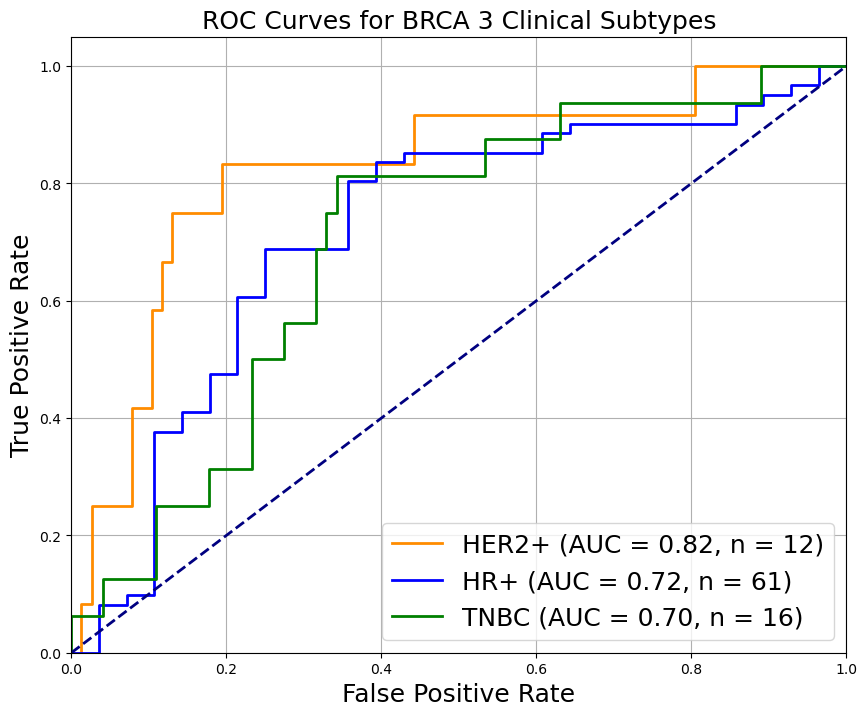

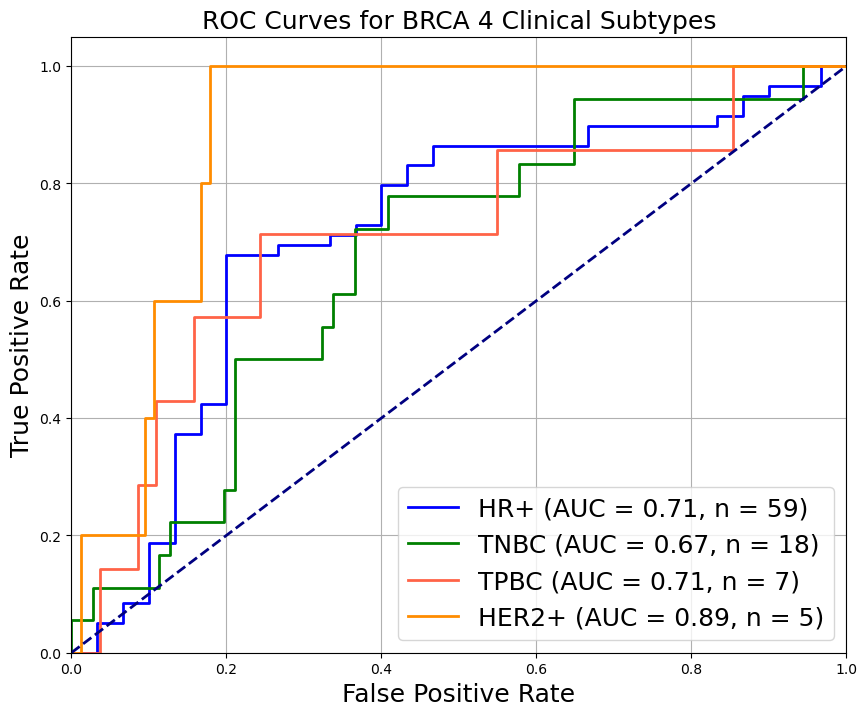

In [8]:
plot_combined_roc_curves(
    external_predictions_df,
    subtypes_3,
    'ROC Curves for BRCA 3 Clinical Subtypes',
    'roc_3_subtypes.png'
)

plot_combined_roc_curves(
    external_predictions_df,
    subtypes_4,
    'ROC Curves for BRCA 4 Clinical Subtypes',
    'roc_4_subtypes.png'
)

